In [2]:
import pandas as pd
import sklearn
import matplotlib.pyplot as plt

train_df = pd.read_csv("https://storage.googleapis.com/kaggle-competitions-data/kaggle/5407/train.csv?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1528096567&Signature=kkMTTBCgUIArj3bzZf1b%2FVDzL8TmYoKQ%2Ft%2F1i50vu4vfICWTiytExYNVqyr%2BANBvD0m6LW7DuCf5z3UfxIzemblU6jm7JGJ7NHD3Px0mrlFJB7FGJjh0BAgZmtscB4sxIi%2BoQz5BxGwWBX7ZGGfzjY3cxwjCHr1wCh6ZdVyiOYsDtf5GjdViCGOSz8g8WQj%2B%2F11PnYUcIOGAZiFeZshTXv%2Fn5KapDCjeDQ67PCiGFK0eSfvtEfkmx23Ovcbdy9D9z%2FH0W2OKVnYr0xT6XO4S2m3HaA%2BW4tV8RvEHEq4NgPLFcdyUQR8Iepn9g78Bex46BjW%2BA8vyjcJaykf6W6Ne9g%3D%3D")
test_df = pd.read_csv("https://storage.googleapis.com/kaggle-competitions-data/kaggle/5407/test.csv?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1528096640&Signature=X6nHvyCS1XANFRoDPSGj3kEVJg2GA0poVeCYtk1POpPpXuGm3t%2BtqKhvjMlKrdqcJL4HA%2BCd9F0JOZCHDAPcD0VWi5wPMf288dxtU6%2BsoHuU9qY78wz84U%2B1zuESWJ%2FvhLklXx8%2B%2FCPADpk%2BEGPjHe3UMNzxruMiS7hYOZ%2ForydIr4PA78j9bXS83Vnq8dcwX1XVomcTjL4DRywAYRY39dK%2FwwZLaUvz5iERMH3DvDheLbc0O%2BG41caaq0ZLFFrob3SwATj751ubE1M1GaZ%2FF3fi8r0%2B5AA7gA6GN%2F4kABBW1qafCSlnrAz2ZWPUkceXFcsvwrqNJtc3PlxeSCTSsg%3D%3D")

In [ ]:
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, pearsonr

In [411]:
# is numeric? or not? 
cols = train_df.columns
for c in cols:
    col_dtype= train_df[c].dtype
    if col_dtype in ['int64', 'float64']:
        print(True, col_dtype)
    else:
        print(train_df[c][:5])
        print(False, col_dtype)
    #print(np.isnumeric(train_df[c]))

True int64
True int64
0    RL
1    RL
2    RL
3    RL
4    RL
Name: MSZoning, dtype: object
False object
0    65
1    80
2    68
3    60
4    84
Name: LotFrontage, dtype: object
False object
True int64
0    Pave
1    Pave
2    Pave
3    Pave
4    Pave
Name: Street, dtype: object
False object
0    NaN
1    NaN
2    NaN
3    NaN
4    NaN
Name: Alley, dtype: object
False object
0    Reg
1    Reg
2    IR1
3    IR1
4    IR1
Name: LotShape, dtype: object
False object
0    Lvl
1    Lvl
2    Lvl
3    Lvl
4    Lvl
Name: LandContour, dtype: object
False object
0    AllPub
1    AllPub
2    AllPub
3    AllPub
4    AllPub
Name: Utilities, dtype: object
False object
0    Inside
1       FR2
2    Inside
3    Corner
4       FR2
Name: LotConfig, dtype: object
False object
0    Gtl
1    Gtl
2    Gtl
3    Gtl
4    Gtl
Name: LandSlope, dtype: object
False object
0    CollgCr
1    Veenker
2    CollgCr
3    Crawfor
4    NoRidge
Name: Neighborhood, dtype: object
False object
0     Norm
1    Feedr
2     Norm
3

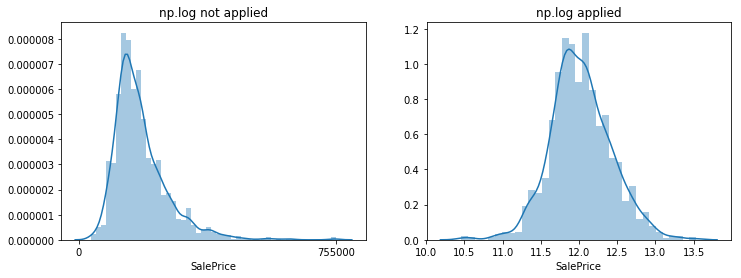

In [354]:
all_cols = train_df.columns

numeric_cols = train_df.corr()['SalePrice'].index
non_numeric_cols = list(set(all_cols) - set(numeric_cols))

f, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].set_title("np.log not applied")
axes[0].set_xticks([0, max(train_df['SalePrice'])])
sns.distplot(train_df['SalePrice'], ax=axes[0])
axes[1].set_title("np.log applied")
sns.distplot(np.log(train_df['SalePrice']), ax=axes[1])
#plt.savefig
plt.show()

# for numeric cols 

In [371]:

"""
- corr로 계산하면, numeric column들에 대해서만 계산됨.
- class 별로 서로 다른 분포를 가진다고 하면, class 별로 서로 다른 model을 세워서 적용하는 것 또한 하나의 방법이 됨 
- 
"""

train_df['log_SalePrice'] = np.log(train_df['SalePrice'])

"""numeric columns에 대해서는 평균으로 fillna를 모두 채워준다. 
"""
numeric_cols = train_df.corr()['SalePrice'].index
train_df[numeric_cols] = train_df[numeric_cols].fillna(lambda col: mean(col))

## 상위 부터 가져와보자. 
corr_df = pd.DataFrame({"corr":train_df.corr()['log_SalePrice'].sort_values(ascending=False).values[2:],
                       }, 
                       index = train_df.corr()['log_SalePrice'].sort_values(ascending=False).index[2:])
"""
- skewness가 높은 경우에는, 일괄적으로 np.log를 해주는 것이 좋은가? 
"""
corr_df['skew'] = train_df[corr_df.index].skew()
corr_df

,corr,skew
OverallQual,0.817184,0.216944
GrLivArea,0.700927,1.366560
GarageCars,0.680625,-0.342549
GarageArea,0.650888,0.179981
TotalBsmtSF,0.612134,1.524255
1stFlrSF,0.596981,1.376757
FullBath,0.594771,0.036562
YearBuilt,0.586570,-0.613461
YearRemodAdd,0.565608,-0.503562
TotRmsAbvGrd,0.534422,0.676341


In [394]:


pearsonr(np.log(train_df['SalePrice']), train_df['OverallQual'])

(0.81718441792168339, 0.0)

In [353]:

skew(train_df['log_SalePrice'])

0.1212103673013655

In [350]:

a = np.random.normal(0, 1, 10)
skew(a)

0.47480782422478895

In [227]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import sklearn
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
"""
data exploration 을 해야 하는데, 
- numerical categorical 분류하고, 
- correlation matrix를 뽑아보자. 
"""
def preprocessingX(input_df):
    X = input_df[['OverallQual', 'OverallCond', 'GrLivArea', 'GarageCars', 'GarageArea', 'TotalBsmtSF', '1stFlrSF', 'FullBath',
                  'TotRmsAbvGrd', 'YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'MasVnrArea', 'Fireplaces', 'YrSold',
                  'BsmtFinSF1', 'LotFrontage', 'WoodDeckSF', '2ndFlrSF', 'OpenPorchSF', 'HalfBath', 'LotArea'
             ]]
    for col in ['SaleCondition', 'SaleType', 'Street', 'BldgType', 'Condition1', 'ExterQual', 'ExterCond',
                'Functional'
               ]:
        X = X.join(pd.get_dummies(input_df[col], prefix=col))
    X = X.fillna(X.mean())
    X = pd.DataFrame(MinMaxScaler().fit_transform(X), columns=X.columns)
    return X
X = preprocessingX(train_df)
notX = train_df[ list(set(train_df.columns) - set(X.columns)) ]
Y = np.log(train_df['SalePrice'])


#train_x, test_x, train_y, test_y = train_test_split(X, Y, train_size=0.7, test_size=0.3, random_state=42)

models = {
    #'linreg': GridSearchCV( LinearRegression(), {}),
    #'Ridge': GridSearchCV(Ridge(), {'alpha':[0.00001, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0]}),
    #'Lasso': GridSearchCV(Lasso(), {'alpha':[0.00001, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0]}),
    'ElasticNet': GridSearchCV(ElasticNet(), {'alpha':[0.001, 0.01, 0.1, 0.5, 1.0]}, cv=3),
    'rf1': GridSearchCV(RandomForestRegressor(), {'n_estimators':[2, 5]}, cv=3),
    'rf2': GridSearchCV(RandomForestRegressor(), {'n_estimators':[50]}, cv=3)
}
"""
    'MLPRegressor': GridSearchCV(MLPRegressor(), {'hidden_layer_sizes':[[10, 20, 10], [10, 10, 10, 10],
                                                                        #[32, 128, 256, 128, 32, 2]
                                                                       ],
                                              'activation':['relu', 'logistic'], 'solver':['adam']
                                             }),


"""


for k, m in models.items():
    m.fit(X, Y)
    print(k)
    print("train score: {:.3f}".format(m.score(X, Y)))
    print("mse: {}".format(mean_squared_error(Y, m.predict(X))))
    print("----------")
# notX.corr()['SalePrice'].sort_values(ascending=False)


best_model = sorted([m for k, m in models.items()], key=lambda m: m.score(X,Y))[-1]
#print(best_model)

for r in np.linspace(0.0, 1.0, 10):
    y_pred = models['rf1'].predict(X)*r + models['rf2'].predict(X)*(1-r)
    print(mean_squared_error(Y, y_pred))



pd.DataFrame({'Id':test_df['Id'], 
              'SalePrice':np.exp(best_model.predict(preprocessingX(test_df)))}).to_csv(
    "180601_houseprice.csv", index=False)
print("complete")


ElasticNet
train score: 0.869
mse: 0.020858482391253697
----------
rf1
train score: 0.964
mse: 0.005712310119705426
----------
rf2
train score: 0.980
mse: 0.00313364823227462
----------
0.00313364823227
0.00310306751573
0.00315176147519
0.00327973011066
0.00348697342214
0.00377349140963
0.00413928407313
0.00458435141265
0.00510869342817
0.00571231011971
complete


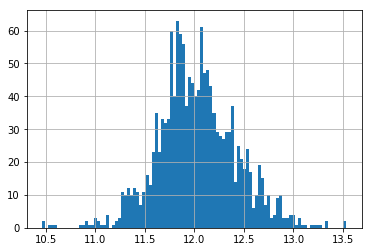

In [238]:
"""
그런데, 단순히 이렇게 normalization하는 것만으로 의미가 있나?
- 차이가 있다면, 차이가 더 있도록 만들고, 차이가 없다면 차이를 줄이도록 변수를 조절하는 것이 중요함. 
- normalization을 하는 것은 이 차이를 두드러지게 만들기 위함. 
"""
import seaborn as sns 

train_df['SalePrice'].apply(lambda x: np.log(x)).hist(bins=100)
plt.show()

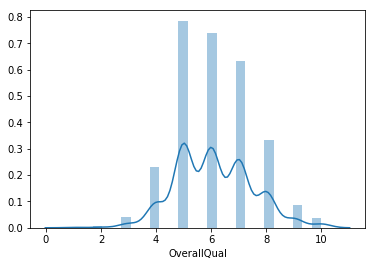

In [241]:
import seaborn as sns 

sns.distplot(train_df['OverallQual'])
plt.show()

In [182]:
test_df['HouseStyle'].isnull().sum()

0

In [149]:
notX['SaleType'].isnull().sum()

0

In [ ]:
pd.concat()